In [4]:
from pathlib import Path

import seaborn as sns
import pandas as pd

from ihop.community2vec import GensimCommunity2Vec

In [5]:

DATA_ROOT = Path("../data")
C2V_ROOT = DATA_ROOT / "community2vec"
MONTHS = sorted(["2021-04", "2021-05", "2021-06", "2021-07", "2021-08", "2021-09", "2021-10", "2021-11", "2021-12", "2022-01", "2022-02", "2022-03"
])

C2V_MODELS = [GensimCommunity2Vec.load(C2V_ROOT / f"RC_{m}"/"best_model") for m in MONTHS]

SUBREDDIT_COUNTS_CSVS = [C2V_ROOT / f"RC_{m}" / "subreddit_counts.csv" for m in MONTHS]

# Basic Comparison of Top Most Popular Subreddits Month-to-Month

In order to build the community2vec models, we kept the top 10K subreddits in each month by number of comments posted. Since the top subreddits will change over time, we need to know quickly and by how much. This can be determined using the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index) of the top subreddits between each month. Let $S_1$ and $S_2$ be the top 10K subreddits for months 1 and 2 respectively, then the similarity and diversity of top subreddits between those months is $\frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}$.

In [6]:
C2V_N_NEAREST_NEIGHBORS = 10
# Jaccard index for subreddits in community2vec models for each month in our year's worth of Reddit data
records = []
for i, model in enumerate(C2V_MODELS):
    month_label = MONTHS[i]
    print("Processing month:", month_label)
    current_model_keys = set(model.get_index_to_key())
    
    # Build up union and intersection values both for overall top subreddits and 
    # nearest neighbors under c2v models
    for j, model2 in enumerate(C2V_MODELS):
        month2_label = MONTHS[j]
        current_model2_keys = set(model2.get_index_to_key())
        union = current_model_keys.union(current_model2_keys)
        union_size = len(union)
        intersection_size = len(current_model_keys.intersection(current_model2_keys))

        rolling_sum_c2v_jaccard = 0

        # Check how much overlap there is between the nearest neighbors in the 
        # community2vec models
        for w in current_model_keys:
            nn_intersection_size = 0
            nn_union_size = C2V_N_NEAREST_NEIGHBORS
            model1_nearest_neighbors = set(model.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
            if w in model2.w2v_model.wv:
                model2_nearest_neighbors = set(model2.get_nearest_neighbors(w, topn=C2V_N_NEAREST_NEIGHBORS))
                nn_intersection_size = len(model1_nearest_neighbors.intersection(model2_nearest_neighbors))
                nn_union_size = len(model1_nearest_neighbors.union(model2_nearest_neighbors))
            subreddit_ji_index = nn_intersection_size / nn_union_size
            rolling_sum_c2v_jaccard += subreddit_ji_index

        
        c2v_nn_jaccard_avg = rolling_sum_c2v_jaccard / len(current_model_keys)
    
        records.append((month_label, month2_label, union_size, intersection_size, c2v_nn_jaccard_avg))
    
top_subreddit_ji_dataframe = pd.DataFrame.from_records(records, 
        columns = [
            "Month 1", 
            "Month 2", 
            "Union Size", 
            "Intersection Size", 
            f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index"])
top_subreddit_ji_dataframe["Jaccard Index"] = top_subreddit_ji_dataframe["Intersection Size"] / top_subreddit_ji_dataframe["Union Size"]

display(top_subreddit_ji_dataframe)

Processing month: 2021-04
Processing month: 2021-05
Processing month: 2021-06
Processing month: 2021-07
Processing month: 2021-08
Processing month: 2021-09
Processing month: 2021-10
Processing month: 2021-11
Processing month: 2021-12
Processing month: 2022-01
Processing month: 2022-02
Processing month: 2022-03


,Month 1,Month 2,Union Size,Intersection Size,Community2vec Top 10 Nearest Subreddit Neighbors Jaccard Index,Jaccard Index
0,2021-04,2021-04,10000,10000,1.000000,1.000000
1,2021-04,2021-05,10805,9195,0.391981,0.850995
2,2021-04,2021-06,11128,8872,0.360147,0.797268
3,2021-04,2021-07,11350,8650,0.339040,0.762115
4,2021-04,2021-08,11466,8534,0.327428,0.744287
...,...,...,...,...,...,...
139,2022-03,2021-11,11501,8499,0.333720,0.738979
140,2022-03,2021-12,11375,8625,0.342240,0.758242
141,2022-03,2022-01,11202,8798,0.357977,0.785395
142,2022-03,2022-02,10749,9251,0.393537,0.860638


Text(0.5, 1.0, 'Similarity between the Top Subreddits for each Month')

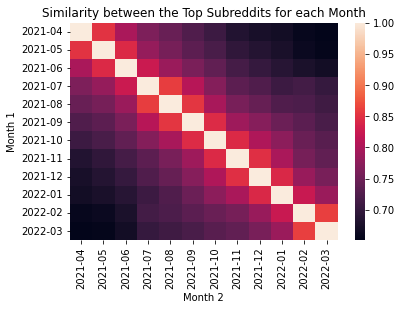

In [7]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = "Jaccard Index")).set_title("Similarity between the Top Subreddits for each Month")

Text(0.5, 1.0, 'Average Similarity between the Top 10 Nearest Subreddits in the Community2vec Model for each Month')

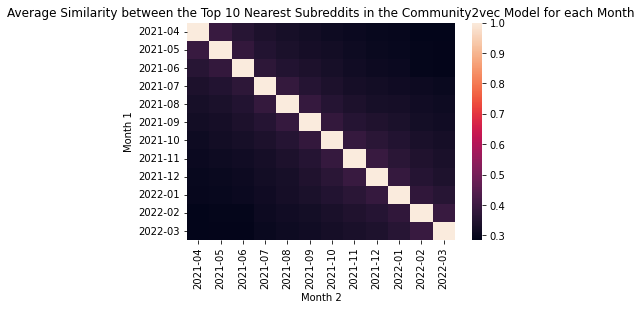

In [8]:
sns.heatmap(top_subreddit_ji_dataframe.pivot(index = "Month 1", columns = "Month 2", values = f"Community2vec Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddit Neighbors Jaccard Index")).set_title(f"Average Similarity between the Top {C2V_N_NEAREST_NEIGHBORS} Nearest Subreddits in the Community2vec Model for each Month")

The closer to 1 the values are, the more similar the top subreddits are between those two months. This plot shows that months closer in time have more top subreddits in common that months further apart in time. 

# Month-to-month Cluster Stability Comparison
We'd like to measure how much variation there is between the k-means clusters of subreddits based on the community2vec embeddings created from each month of Reddit comment data. 

Here, we use a single community2vec model for each month (don't vary the community2vec models). Each month's community2vec model is used to train 10 k-means models where the random seed for the cluster model is varied, then the inter- and intra-month stability for each cluster model is measured. We also vary the number of clusters allowed for each. For each number of clusters, 

The intra-month values (training multiple k-means models from same community2vec model for a single month) will tell us how sensitive the k-means clusters are to random initialization within the same time range and community2vec model. We expect these values to be low relative to inter-month values. If they are high, it's an indication that the clusterings are sensitive to random initializations and indicates they may be difficult to use for research purposes. 

The inter-month values (training multiple k-means models for two separate months and doing many pairwise comparisons) will tell us how much the clusterings change over time. In most cases, we expect these values to be low when comparing two months that are close together in time, but higher for months that are far apart. In other words, these metrics should give an indication of how much Reddit clusterings change as time goes on. However, there's the possibility for these values to be high when drastic changes occur on Reddit, such as when certain subreddits spike in popularity or are banned. In such cases, the inter-month stability metrics could serve as an indicator of large changes in Reddit's "geography". 